In [1]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np
import pandas as pd
import scipy.spatial.distance as scidist
import matplotlib.pyplot as plt
import invisible_cities.core.fit_functions  as fitf
from   invisible_cities.core.stat_functions import poisson_sigma
from invisible_cities.core.core_functions import shift_to_bin_centers
import invisible_cities.reco.dst_functions  as dstf

In [2]:
import utils.histo_functions as myhf

In [3]:
### Useful parameters for plots
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 10, 7.5
plt.rcParams['figure.max_open_warning']= 0

In [4]:
color_table = myhf.tableau20

blue = color_table[0]
orange = color_table[2]
green = color_table[4]
fucsia = color_table[6]
pink = color_table[7]
lilla = color_table[9]
brown = color_table[10]

## NEXT color
r, g, b = (218, 60, 78)
next_color = (r / 255., g / 255., b / 255.)
r, g, b = (35, 180, 203)
data_color = (r / 255., g / 255., b / 255.)

### BEERSHEBA: configuration: 5x5x5 mm voxels

In [5]:
tracks_list = []

radius = 21

folder_name = f'/data_extra2/paolafer/SimMC/next100/tracks/R{radius}mm/'
start = 1
nfiles = 1000
for file in range(start, start+nfiles):
    filename = folder_name + f'next100.e-_roi.{file}.skel_tracks.R{radius}mm.h5'
    try:
        df_t = pd.read_hdf(filename, 'Tracks')
    except:
        print('File {} not good'.format(filename))
        continue
    tracks_list.append(df_t)
    
tracks = pd.concat([dt for dt in tracks_list]) 
tracks.loc[:, 'evt_energy'] = tracks.groupby('event')['energy'].transform('sum')
tracks.loc[:, 'e_max']      = tracks.groupby('event')['energy'].transform('max')

In [6]:
tracks.columns

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

In [10]:
evt_energy = tracks.groupby('event').energy.sum()

In [8]:
n_events_ini = tracks.event.nunique()
print(n_events_ini)

9787


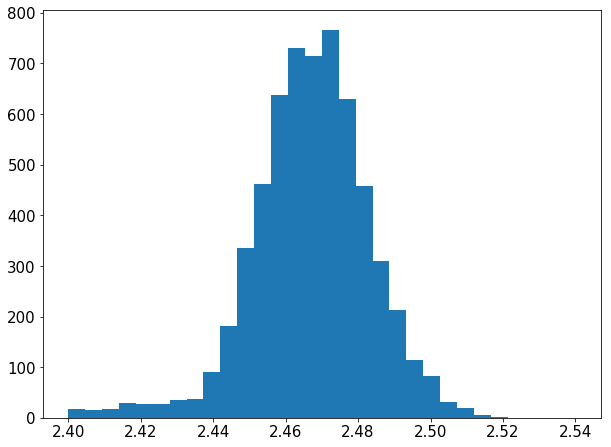

In [11]:
plt.hist(evt_energy, bins=30, range = (2.4, 2.54));
#plt.yscale('log')

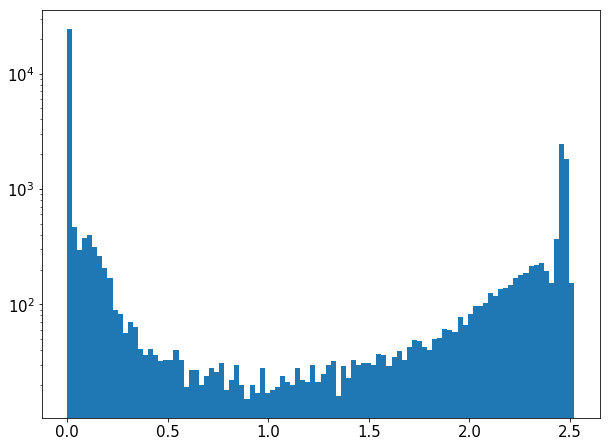

In [12]:
plt.hist(tracks.energy, bins=100);
plt.yscale('log')

### Fiducial limits


In [13]:
veto = 20 # mm
r_max = 492 - veto
z_min = veto
z_max = 1205 - veto
print(f'r max = {r_max} mm, z min = {z_min} mm, z max = {z_max} mm')

## Returns df with events with ALL tracks within fiducial limits
def fiducialize_df(df, rmax, zmin, zmax):
    fid_sel = (df.r_max < rmax) & (df.z_min > zmin) & (df.z_max < zmax)
    fid_trks     = df[fid_sel]
    not_fid_trks = df[~fid_sel]

    not_fid_events =  not_fid_trks.event.unique() # list of event IDs where at least 1 track is not fiducial
    evt_fid_sel    = ~fid_trks.event.isin(not_fid_events) # true if event ID is not in the above list
    fid = fid_trks[evt_fid_sel] # tracks within fiducial limits
    return fid

r max = 472 mm, z min = 20 mm, z max = 1185 mm


### Fiducial + 1 track + no overlap

Events after fiducial cut: 6478, efficiency = 0.6618984367017472
Events after 1-track cut: 1388, efficiency = 0.21426366162395802
Events after no-overlap cut: 1348, efficiency = 0.9711815561959655


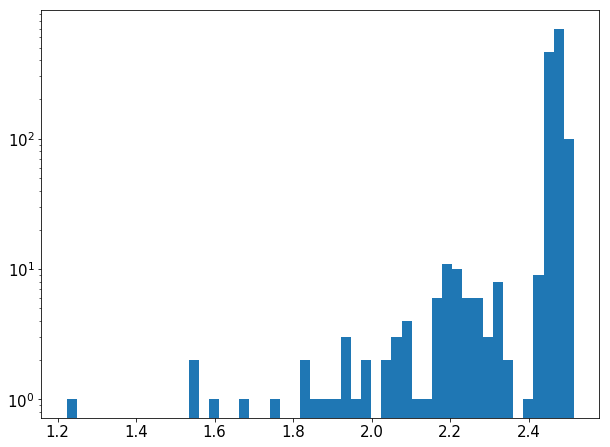

In [14]:
fid = fiducialize_df(tracks, r_max, z_min, z_max)
n_events_fid = fid.event.nunique()
print(f'Events after fiducial cut: {n_events_fid}, efficiency = {n_events_fid/n_events_ini}')
one_track = fid[fid.numb_of_tracks == 1]
n_events_1track = one_track.event.nunique()
print(f'Events after 1-track cut: {n_events_1track}, efficiency = {n_events_1track/n_events_fid}')
sep = one_track[one_track.ovlp_blob_energy == 0.]
n_events_no_overlap = sep.event.nunique()
print(f'Events after no-overlap cut: {n_events_no_overlap}, efficiency = {n_events_no_overlap/n_events_1track}')

plt.hist(sep.energy, bins=50);
plt.yscale('log')

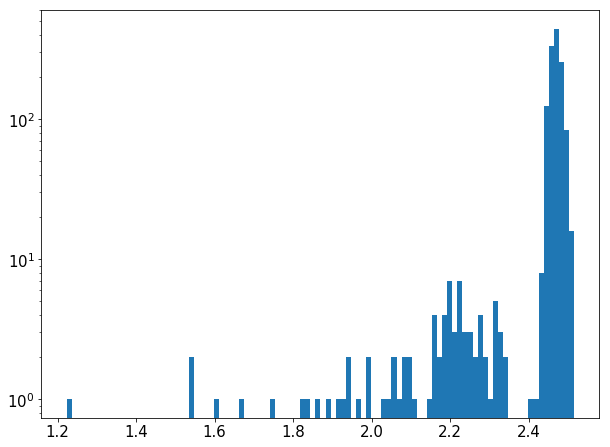

In [15]:
evt_energy = sep.groupby('event').energy.sum()
plt.hist(evt_energy, bins=100);
plt.yscale('log')

In [16]:
e_roi_min = 2.4 # MeV
e_roi_max = 2.54 # MeV

roi = sep[(sep.evt_energy > e_roi_min) & (sep.evt_energy < e_roi_max)]
n_events_roi = roi.event.nunique()
print(f'Events after roi cut: {n_events_roi}, efficiency = {n_events_roi/n_events_no_overlap}')

Events after roi cut: 1268, efficiency = 0.9406528189910979


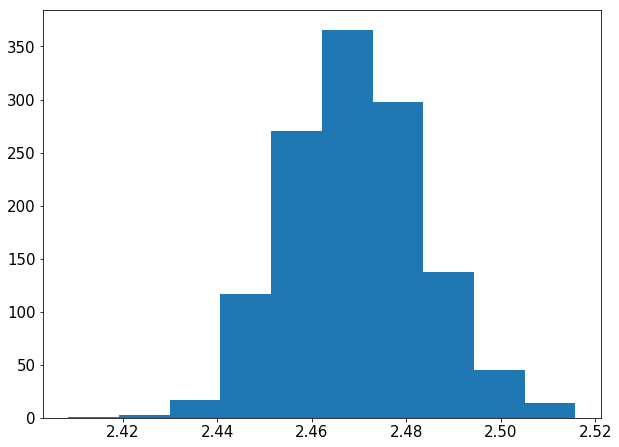

In [18]:
plt.hist(roi.evt_energy, bins=10);

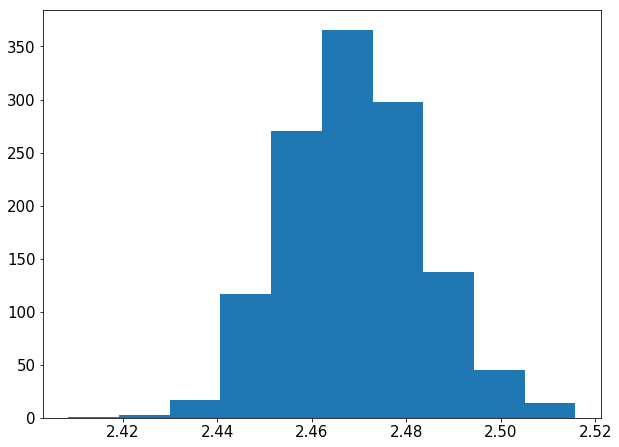

In [19]:
plt.hist(roi.e_max, bins=10);

### Blobs

In [20]:
roi = roi[roi.eblob1 > 0]
n_events_good_roi = roi.event.nunique()
print(f'Events with no bad reconstructed tracks: {n_events_good_roi}, efficiency = {n_events_good_roi/n_events_roi}')

Events with no bad reconstructed tracks: 1268, efficiency = 1.0


In [21]:
length   = roi.length.values
n_voxels = roi.numb_of_voxels.values
eblob1   = roi.eblob1.values
eblob2   = roi.eblob2.values

In [22]:
len(eblob1)

1268

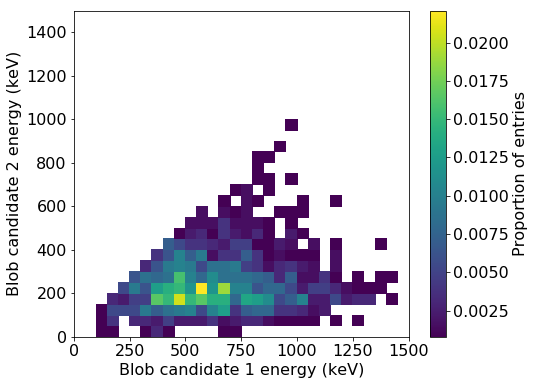

In [23]:
fig = plt.figure(1);
fig.set_figwidth(7.5);
fig.set_figheight(6.);

plt.rcParams.update({'font.size': 16})

weights = myhf.get_weights(eblob1, True)

bins_blobs = 30
range_blobs = 1500
_, _, _, _ = plt.hist2d(eblob1*1000, eblob2*1000, weights=weights, bins=bins_blobs, \
                        range=((0, range_blobs), (0, range_blobs)), cmin=0.0000001)
plt.xlabel("Blob candidate 1 energy (keV)")
plt.ylabel("Blob candidate 2 energy (keV)")
#plt.title('')
#plt.clim(0.0000001, 0.028)
plt.colorbar(label='Proportion of entries');

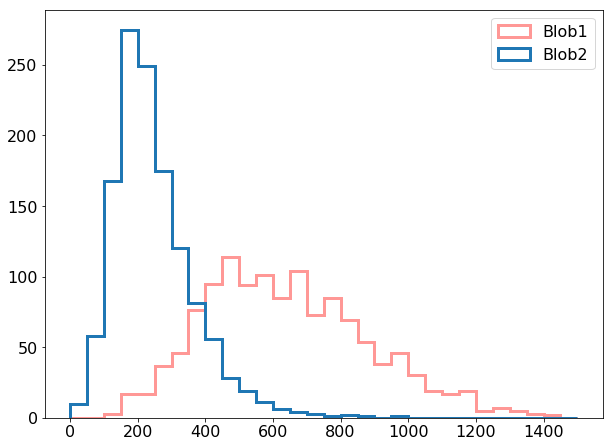

In [24]:
h1 = plt.hist(eblob1*1000, bins=bins_blobs, range=(0, range_blobs), color=pink, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='Blob1');
h2 = plt.hist(eblob2*1000, bins=bins_blobs, range=(0, range_blobs), color=blue, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='Blob2');
plt.legend(loc=1);

In [25]:
roi.event

0       5
0      20
0      23
0      29
0      39
0      41
0      49
0      52
0      63
0      64
0      65
0      72
0      81
0      83
0      88
0      89
0      94
0      95
0     103
0     116
0     127
0     159
0     163
0     176
0     188
0     202
0     218
0     232
0     266
0     277
     ... 
0    9770
0    9779
0    9807
0    9808
0    9811
0    9814
0    9818
0    9842
0    9844
0    9850
0    9853
0    9855
0    9862
0    9863
0    9872
0    9875
0    9885
0    9887
0    9899
0    9915
0    9916
0    9921
0    9927
0    9933
0    9946
0    9949
0    9950
0    9972
0    9978
0    9996
Name: event, Length: 1268, dtype: int64

In [26]:
bckg = []
bckg_err = []

before = len(roi)
for thr in range(0, 600, 5):
    after = len(roi[roi.eblob2*1000 > thr])
    b = after/before
    err_b = np.sqrt((1-b)/before)
    bckg.append(1-b)
    bckg_err.append(err_b)
    
bckg_rej = np.array(bckg)
err_bckg = np.array(bckg_err)     

npz_file = f'/home/paolafer/bckg_beersheba_skel_R{radius}mm_conf1'
np.savez(npz_file, bckg_rej=bckg_rej, err_bckg=err_bckg)

### Second way: do fiducial and overlap cuts + roi and use only main track.

In [99]:
fid = fiducialize_df(tracks, r_max, z_min, z_max)
n_events_fid = fid.event.nunique()
print(f'Events after fiducial cut: {n_events_fid}, efficiency = {n_events_fid/n_events_ini}')

sep = fid[fid.ovlp_blob_energy == 0.]
n_events_no_overlap = sep.event.nunique()
print(f'Events after no-overlap cut: {n_events_no_overlap}, efficiency = {n_events_no_overlap/n_events_fid}')

Events after fiducial cut: 6478, efficiency = 0.6618984367017472
Events after no-overlap cut: 6237, efficiency = 0.9627971596171658


In [75]:
fid[fid.event == 43]

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,evt_energy,e_max
0,43,0,1.816075,79.929974,364,14682,7,304.5,178.5,853.223125,...,188.952381,864.930109,1.387212,0.210126,-77,4.913043,4.826087,4.897438,1.820912,1.816075
1,43,1,0.003250,13.773759,9,139,7,373.5,262.5,860.954625,...,1000000.000000,1000000.000000,1.387212,0.210126,-1,4.913043,4.826087,4.897438,1.820912,1.816075
2,43,2,0.000647,11.712967,5,32,7,253.5,196.5,860.954625,...,1000000.000000,1000000.000000,1.387212,0.210126,-1,4.913043,4.826087,4.897438,1.820912,1.816075
3,43,3,0.000605,6.886880,4,28,7,405.5,190.5,864.873625,...,1000000.000000,1000000.000000,1.387212,0.210126,-1,4.913043,4.826087,4.897438,1.820912,1.816075
4,43,4,0.000255,6.886880,3,13,7,268.5,264.5,860.954625,...,1000000.000000,1000000.000000,1.387212,0.210126,-1,4.913043,4.826087,4.897438,1.820912,1.816075
5,43,5,0.000059,0.000000,1,3,7,185.5,209.5,859.007875,...,1000000.000000,1000000.000000,1.387212,0.210126,-1,4.913043,4.826087,4.897438,1.820912,1.816075
6,43,6,0.000019,0.000000,1,1,7,314.5,289.5,859.007875,...,1000000.000000,1000000.000000,1.387212,0.210126,-1,4.913043,4.826087,4.897438,1.820912,1.816075


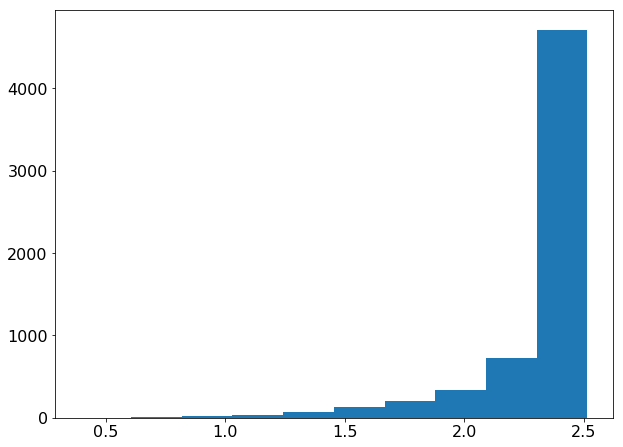

In [88]:
plt.hist(sep.energy, bins=10);

In [89]:
e_roi_min = 2.4 # MeV
e_roi_max = 2.54 # MeV

sel_tracks = tracks[tracks.event.isin(sep.event.unique())]
roi        = sel_tracks[(sel_tracks.energy > e_roi_min) & (sel_tracks.energy < e_roi_max)]

n_events_roi = roi.event.nunique()
print(f'Events after roi cut: {n_events_roi}, efficiency = {n_events_roi/n_events_no_overlap}')

Events after roi cut: 4249, efficiency = 0.6812570145903479


In [100]:
n_events_roi/n_events_ini

0.434147338305916

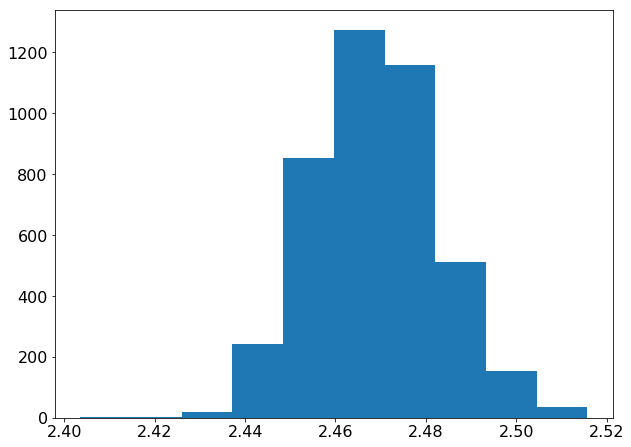

In [90]:
plt.hist(roi.evt_energy, bins=10);

In [91]:
### Use only track with maximum energy
sel_sample   = roi[roi.energy == roi.e_max]
n_sel_sample = sel_sample.event.nunique()
sel_sample   = sel_sample[sel_sample.eblob1 > 0]
n_events_good_sample = sel_sample.event.nunique()
print(f'Events with no bad reconstructed tracks: {n_events_good_sample}, efficiency = {n_events_good_sample/n_sel_sample}')
#sel_sample = sel_sample[sel_sample.eblob1 < 0.1]

Events with no bad reconstructed tracks: 4249, efficiency = 1.0


In [79]:
sel_sample.event

0       3
0       5
0       6
0      10
0      11
0      15
0      17
0      20
0      21
0      23
0      24
0      28
0      29
0      30
0      31
0      36
0      39
0      41
0      44
0      46
0      47
0      48
0      49
0      50
0      52
0      54
0      55
0      56
0      58
0      59
     ... 
0    9940
0    9946
0    9949
0    9950
0    9951
0    9953
0    9955
0    9958
0    9959
0    9963
0    9966
0    9967
0    9969
0    9970
0    9972
0    9974
0    9975
0    9977
0    9978
0    9980
0    9984
0    9986
0    9987
0    9988
0    9989
0    9991
0    9993
0    9995
0    9996
0    9997
Name: event, Length: 5086, dtype: int64

In [92]:
length   = sel_sample.length.values
n_voxels = sel_sample.numb_of_voxels.values
eblob1   = sel_sample.eblob1.values
eblob2   = sel_sample.eblob2.values

In [93]:
len(eblob1)

4249

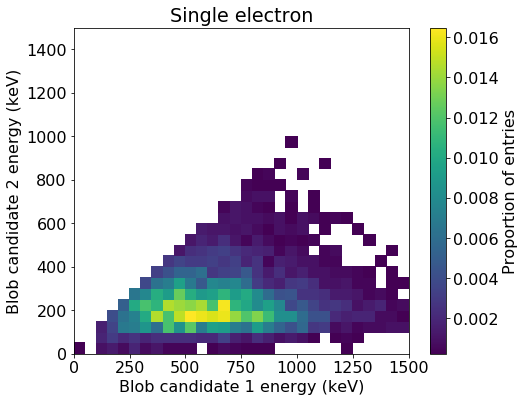

In [97]:
fig = plt.figure(1);
fig.set_figwidth(7.5);
fig.set_figheight(6.);

plt.rcParams.update({'font.size': 16})

weights = myhf.get_weights(eblob1, True)

bins_blobs = 30
range_blobs = 1500
_, _, _, _ = plt.hist2d(eblob1*1000, eblob2*1000, weights=weights, bins=bins_blobs, \
                        range=((0, range_blobs), (0, range_blobs)), cmin=0.0000001)
plt.xlabel("Blob candidate 1 energy (keV)")
plt.ylabel("Blob candidate 2 energy (keV)")
plt.title('Single electron')
#plt.clim(0.0000001, 0.028)
plt.colorbar(label='Proportion of entries');

In [98]:
fig.savefig('elec.blobs.pdf')

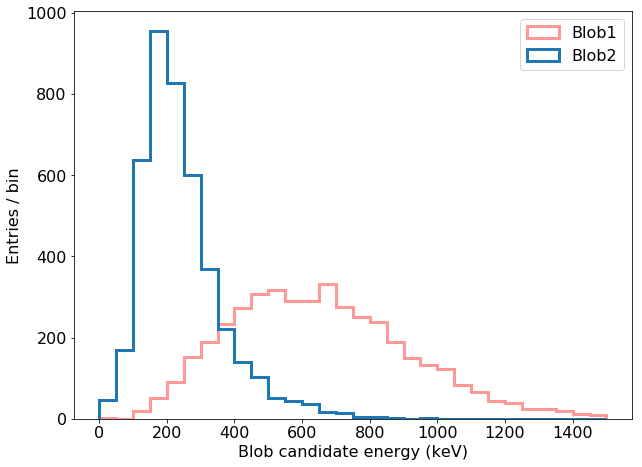

In [95]:
fig = plt.figure(1)
h1 = plt.hist(eblob1*1000, bins=bins_blobs, range=(0, range_blobs), color=pink, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='Blob1');
h2 = plt.hist(eblob2*1000, bins=bins_blobs, range=(0, range_blobs), color=blue, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='Blob2');
plt.xlabel("Blob candidate energy (keV)")
plt.ylabel("Entries / bin");
plt.legend(loc=1);

In [85]:
fig.savefig('elec.blobs1dim.pdf')

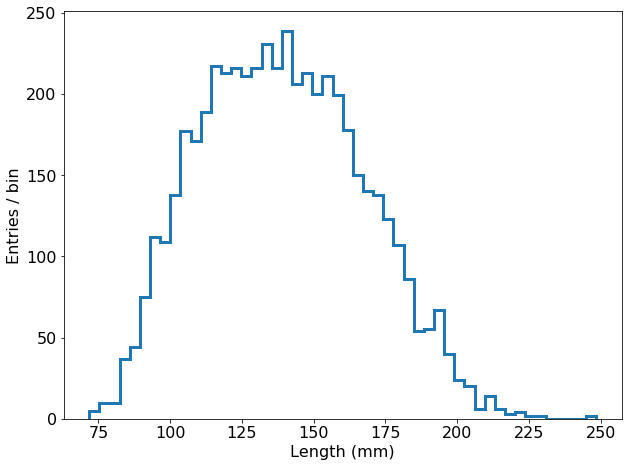

In [38]:
h1 = plt.hist(length, bins=50, linewidth=3, histtype='step', \
                 stacked=True, fill=False);
plt.xlabel("Length (mm)")
plt.ylabel("Entries / bin");

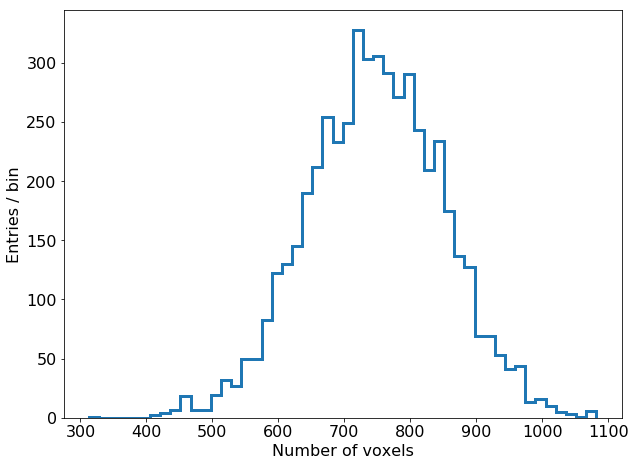

In [39]:
h1 = plt.hist(n_voxels, bins=50,linewidth=3, histtype='step', \
                 stacked=True, fill=False);
plt.xlabel("Number of voxels")
plt.ylabel("Entries / bin");

In [96]:
bckg = []
bckg_err = []

before = len(sel_sample)
for thr in range(0, 600, 5):
    after = len(sel_sample[sel_sample.eblob2*1000 > thr])
    b = after/before
    err_b = np.sqrt((1-b)/before)
    bckg.append(1-b)
    bckg_err.append(err_b)
    
bckg_rej = np.array(bckg)
err_bckg = np.array(bckg_err)     

npz_file = f'/home/paolafer/bckg_beersheba_skel_R{radius}mm_main_track_roi_conf1'
np.savez(npz_file, eblob1=eblob1, eblob2=eblob2, bckg_rej=bckg_rej, err_bckg=err_bckg)

In [41]:
sel_sample.event

0       3
0       5
0       6
0      10
0      11
0      15
0      17
0      20
0      21
0      23
0      24
0      28
0      29
0      30
0      31
0      36
0      39
0      41
0      44
0      46
0      47
0      48
0      49
0      50
0      52
0      54
0      55
0      56
0      58
0      59
     ... 
0    9940
0    9946
0    9949
0    9950
0    9951
0    9953
0    9955
0    9958
0    9959
0    9963
0    9966
0    9967
0    9969
0    9970
0    9972
0    9974
0    9975
0    9977
0    9978
0    9980
0    9984
0    9986
0    9987
0    9988
0    9989
0    9991
0    9993
0    9995
0    9996
0    9997
Name: event, Length: 5086, dtype: int64

## Use true end-points of tracks

In [42]:
folder_name = '/data_extra2/paolafer/SimMC/next100/hits/'

ehitsblob1, ehitsblob2 = [], []
diff1_x, diff1_y, diff1_z = [], [], []
diff2_x, diff2_y, diff2_z = [], [], []
reco1_x, reco1_y, reco1_z = [], [], []
reco2_x, reco2_y, reco2_z = [], [], []
true1_x, true1_y, true1_z = [], [], []
true2_x, true2_y, true2_z = [], [], []
reco_blob1, reco_blob2 = [], []

nfiles = 1000
start  = 1
bunch  = 20

sel_events = sel_sample.event.unique()
common_events = []

for i in range(start, int(nfiles/bunch)):

    hit_list, part_list = [], []
    for file in range(1 + (i-1)*bunch, 1 + i*bunch):
        filename = folder_name + f'next100.e-_roi.{file}.deconv.h5'
        try:
            df_h = pd.read_hdf(filename, 'DECO/Events')
            df_p = pd.read_hdf(filename, 'MC/particles')
        except:
            print('File {} not good'.format(filename))
            continue
        hit_list.append(df_h)
        part_list.append(df_p)
        
    hits  = pd.concat([dh for dh in hit_list])
    parts = pd.concat([dp for dp in part_list]) 

    for evt in parts.event_id.unique(): 
        
        if evt not in sel_events:
            continue
            
        common_events.append(evt)

        the_part = parts[parts.event_id == evt]
        the_hits = hits[hits.event == evt]
        reco     = sel_sample[sel_sample.event == evt]
    
        primary = the_part[the_part.primary == True]
    
        extreme1 = np.array([primary.final_x.values, primary.final_y.values, primary.final_z.values])
        extreme2 = np.array([primary.initial_x.values, primary.initial_y.values, primary.initial_z.values])       
        
        hit_pos = np.array([the_hits.X.values, the_hits.Y.values, the_hits.Z.values]).transpose()
        hit_e   = the_hits.E
    
        dist1 = scidist.cdist(extreme1.transpose(), hit_pos)
        dist2 = scidist.cdist(extreme2.transpose(), hit_pos)
        
        in_blob1 = dist1 < radius
        in_blob2 = dist2 < radius
        
        true_blob1 = hit_e[in_blob1[0]].sum()
        true_blob2 = hit_e[in_blob2[0]].sum()
                    
       # if true_blob1 < true_blob2:
       #     eblob1 = true_blob2
       #     eblob2 = true_blob1
      #  else:
      #      eblob1 = true_blob1
      #      eblob2 = true_blob2
        
        ehitsblob1.append(true_blob1)
        ehitsblob2.append(true_blob2)
        
        reco_blob1.append(reco.eblob1)
        reco_blob2.append(reco.eblob2)
        
        diff1_x.append(reco.blob1_x.values[0] - extreme1.transpose()[0][0])
        diff1_y.append(reco.blob1_y.values[0] - extreme1.transpose()[0][1])
        diff1_z.append(reco.blob1_z.values[0] - extreme1.transpose()[0][2])
    
        diff2_x.append(reco.blob2_x.values[0] - extreme2.transpose()[0][0])
        diff2_y.append(reco.blob2_y.values[0] - extreme2.transpose()[0][1])
        diff2_z.append(reco.blob2_z.values[0] - extreme2.transpose()[0][2])
        
        reco1_x.append(reco.blob1_x.values[0])
        reco1_y.append(reco.blob1_y.values[0])
        reco1_z.append(reco.blob1_z.values[0])
        reco2_x.append(reco.blob2_x.values[0])
        reco2_y.append(reco.blob2_y.values[0])
        reco2_z.append(reco.blob2_z.values[0])
        
        true1_x.append(extreme1.transpose()[0][0])
        true1_y.append(extreme1.transpose()[0][1])
        true1_z.append(extreme1.transpose()[0][2])
        true2_x.append(extreme2.transpose()[0][0])
        true2_y.append(extreme2.transpose()[0][1])
        true2_z.append(extreme2.transpose()[0][2])
        
        
ehitsblob1 = np.array(ehitsblob1)*1000
ehitsblob2 = np.array(ehitsblob2)*1000

reco_blob1 = np.array(reco_blob1)*1000
reco_blob2 = np.array(reco_blob2)*1000

diff1_x = np.array(diff1_x)
diff2_x = np.array(diff2_x)
diff1_y = np.array(diff1_y)
diff2_y = np.array(diff2_y)

reco1_x = np.array(reco1_x)
reco2_x = np.array(reco2_x)
reco1_y = np.array(reco1_y)
reco2_y = np.array(reco2_y)

true1_x = np.array(true1_x)
true2_x = np.array(true2_x)
true1_y = np.array(true1_y)
true2_y = np.array(true2_y)

common_events = np.array(common_events)

In [260]:
reco.eblob1

0    0.391696
Name: eblob1, dtype: float64

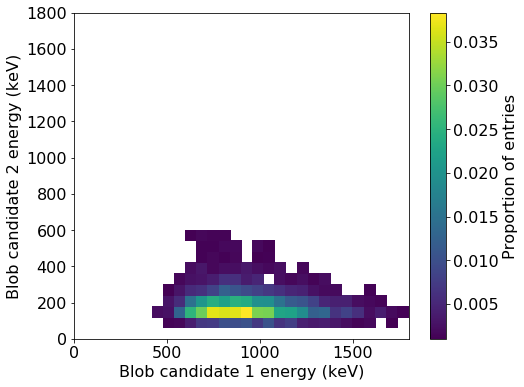

In [43]:
fig = plt.figure(1);
fig.set_figwidth(7.5);
fig.set_figheight(6.);

plt.rcParams.update({'font.size': 16})

weights = myhf.get_weights(ehitsblob1, True)
#print(len(weights))

bins_blobs = 30
range_blobs = 1800
_, _, _, _ = plt.hist2d(ehitsblob1, ehitsblob2, weights=weights, bins=bins_blobs, \
                        range=((0, range_blobs), (0, range_blobs)), cmin=0.001)
plt.xlabel("Blob candidate 1 energy (keV)")
plt.ylabel("Blob candidate 2 energy (keV)")
#plt.title('')
#plt.clim(0.0000001, 0.028)
plt.colorbar(label='Proportion of entries');

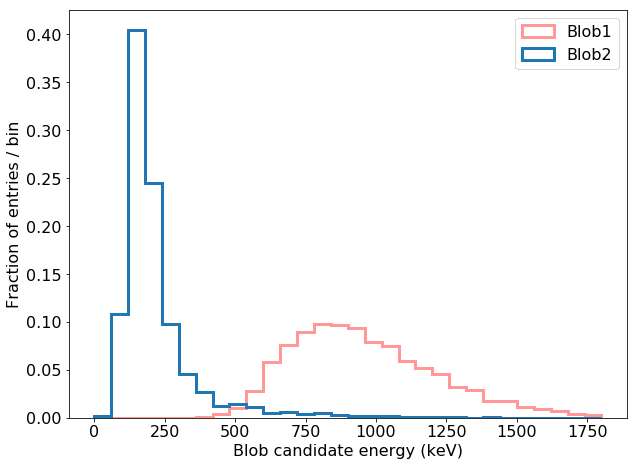

In [44]:
h1 = plt.hist(ehitsblob1, bins=bins_blobs, range=(0, range_blobs), weights=weights, color=pink, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='Blob1');
h2 = plt.hist(ehitsblob2, bins=bins_blobs, range=(0, range_blobs), weights=weights, color=blue, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='Blob2');
plt.xlabel("Blob candidate energy (keV)")
plt.ylabel('Fraction of entries / bin')
plt.legend(loc=1);

In [45]:
print(f'Mean blob1 = {ehitsblob1.mean()} keV, mean blob2 = {ehitsblob2.mean()} keV')

Mean blob1 = 964.2120760952308 keV, mean blob2 = 220.78825304016652 keV


In [59]:
bckg = []
bckg_err = []

before = len(ehitsblob2)
for thr in range(0, 1000, 5):
    after = len(ehitsblob2[ehitsblob2 > thr])
    b = after/before
    err_b = np.sqrt((1-b)/before)
    bckg.append(1-b)
    bckg_err.append(err_b)
    
bckg_rej = np.array(bckg)
err_bckg = np.array(bckg_err)     

npz_file = f'/home/paolafer/bckg_beersheba_skel_R{radius}mm_main_track_true_extr_conf1'
np.savez(npz_file, eblob1=ehitsblob1, eblob2=ehitsblob2, bckg_rej=bckg_rej, err_bckg=err_bckg)

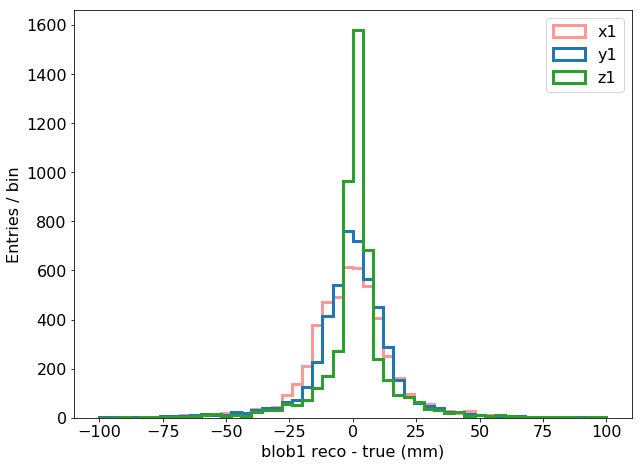

In [47]:
therange = (-100, 100)
h1 = plt.hist(diff1_x, bins=50, color=pink, range=therange, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='x1');
h2 = plt.hist(diff1_y, bins=50, color=blue, range=therange, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='y1');
h3 = plt.hist(diff1_z, bins=50, color=green, range=therange, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='z1');
plt.xlabel("blob1 reco - true (mm)")
plt.ylabel('Entries / bin')
plt.legend(loc=1);

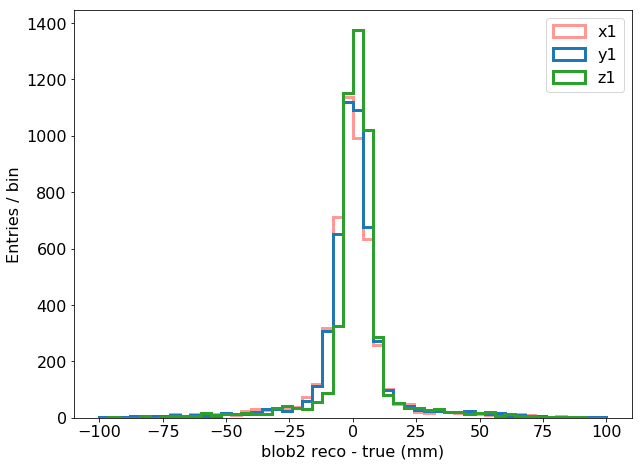

In [48]:
therange = (-100, 100)
h1 = plt.hist(diff2_x, bins=50, color=pink, range=therange, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='x1');
h2 = plt.hist(diff2_y, bins=50, color=blue, range=therange, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='y1');
h3 = plt.hist(diff2_z, bins=50, color=green, range=therange, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='z1');
plt.xlabel("blob2 reco - true (mm)")
plt.ylabel('Entries / bin')
plt.legend(loc=1);

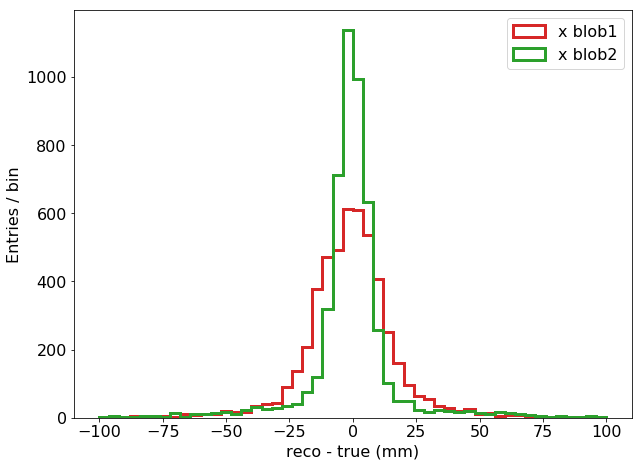

In [49]:
therange = (-100, 100)
h1 = plt.hist(diff1_x, bins=50, range=therange, color=fucsia, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='x blob1');
h1 = plt.hist(diff2_x, bins=50, range=therange, color=green, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='x blob2');
plt.xlabel("reco - true (mm)")
plt.ylabel('Entries / bin')
plt.legend(loc=1);

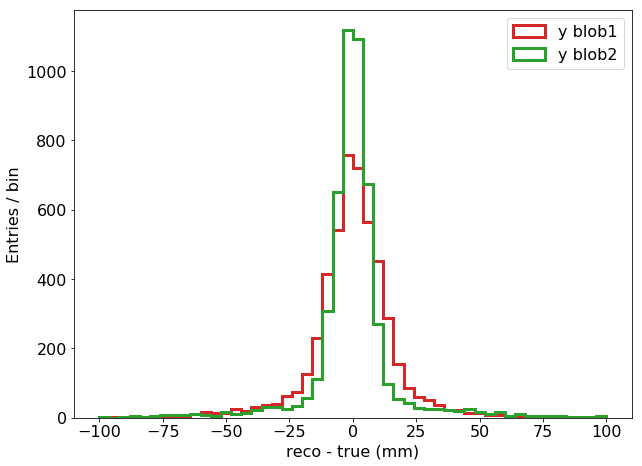

In [50]:
rng = 100 
h1 = plt.hist(diff1_y, bins=50, range=(-rng, rng), color=fucsia, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='y blob1');
h2 = plt.hist(diff2_y, bins=50, range=(-rng, rng), color=green, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='y blob2');
plt.xlabel("reco - true (mm)")
plt.ylabel('Entries / bin')
plt.legend(loc=1);

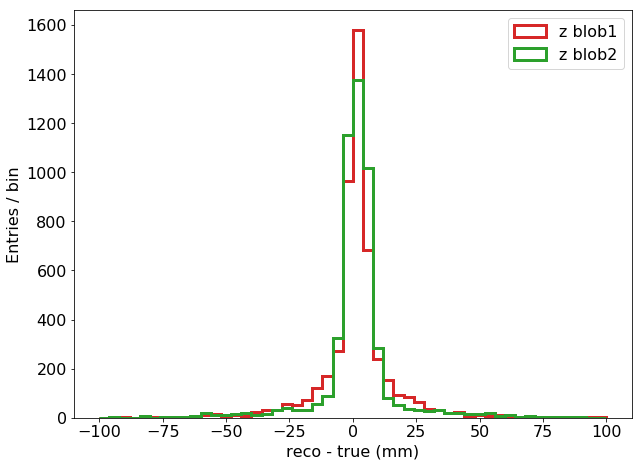

In [51]:
rng = 100 

h1 = plt.hist(diff1_z, bins=50, range=(-rng, rng), color=fucsia, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='z blob1');
h2 = plt.hist(diff2_z, bins=50, range=(-rng, rng), color=green, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='z blob2');
plt.xlabel("reco - true (mm)")
plt.ylabel('Entries / bin')
plt.legend(loc=1);

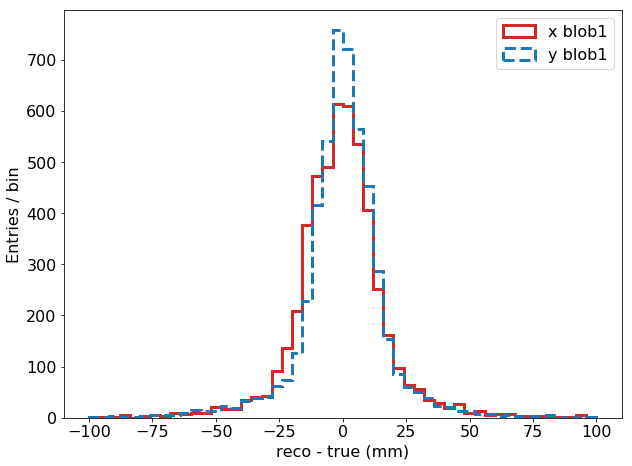

In [72]:
fig = plt.figure(1)
therange = (-100, 100)
h1 = plt.hist(diff1_x, bins=50, range=therange, color=fucsia, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='x blob1');
h1 = plt.hist(diff1_y, bins=50, range=therange, color=blue, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='y blob1', linestyle='dashed');
plt.xlabel("reco - true (mm)")
plt.ylabel('Entries / bin')
plt.legend(loc=1);
fig.savefig('blob1_diff.pdf')

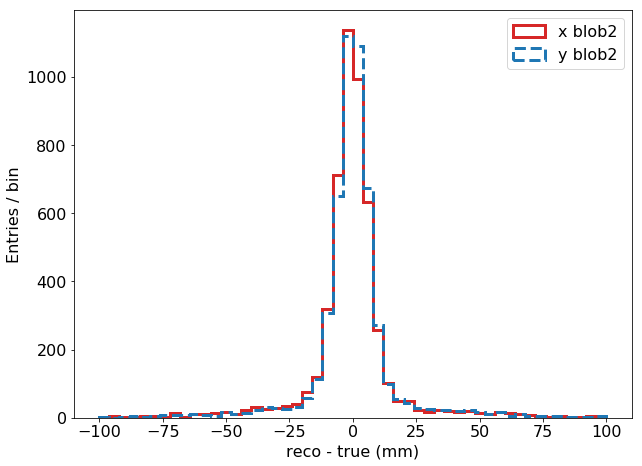

In [71]:
fig = plt.figure(1)
therange = (-100, 100)
h1 = plt.hist(diff2_x, bins=50, range=therange, color=fucsia, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='x blob2');
h1 = plt.hist(diff2_y, bins=50, range=therange, color=blue, linewidth=3, histtype='step', \
                 stacked=True, fill=False, label='y blob2', linestyle='dashed');
plt.xlabel("reco - true (mm)")
plt.ylabel('Entries / bin')
plt.legend(loc=1);

fig.savefig('blob2_diff.pdf')

[ 2.27679676e+04 -1.13168791e+00  1.19583503e+01]
Chi2 = 1.9315311525302175
Mean = -1.1316879060826255 pes
sigma = 11.958350347870347 pes


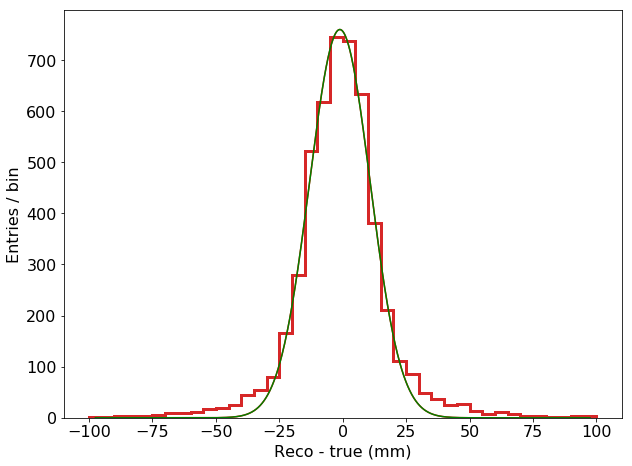

In [54]:
therange = (-100, 100)
y, x, _ =  plt.hist(diff1_x, bins=40, range=therange, color=fucsia, linewidth=3, histtype='step', \
                     stacked=True, fill=False, label='x blob1')
x = shift_to_bin_centers(x)


fit = True

if fit:
    seed  = 1000, 0, 10
    sigma = poisson_sigma(y)
    f     = fitf.fit(myhf.gauss, x, y, seed, fit_range=(-25, 25), sigma=sigma)
    print(f.values)
    #print(f.errors)
    print(f'Chi2 = {f.chi2}')
    print(f'Mean = {f.values[1]} pes')
    print(f'sigma = {f.values[2]} pes')

    xmin = min(x)
    xmax = max(x)
    mx = np.linspace(xmin, xmax, 1000)
    plt.plot(mx, f.fn(mx), 'r')
    plt.plot(mx, myhf.gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-')

    plt.title('')
    plt.xlabel('Reco - true (mm)')
    plt.ylabel('Entries / bin')
    

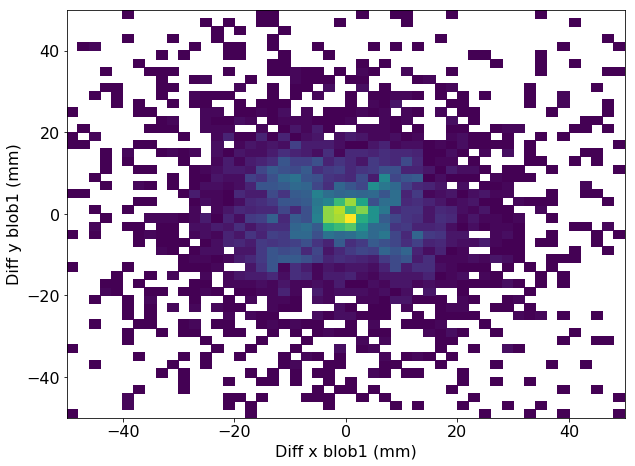

In [55]:
rng = 50 
plt.hist2d(diff1_x, diff1_y, bins=50, range=((-rng, rng), (-rng, rng)), cmin=0.001);
plt.xlabel("Diff x blob1 (mm)")
plt.ylabel("Diff y blob1 (mm)");

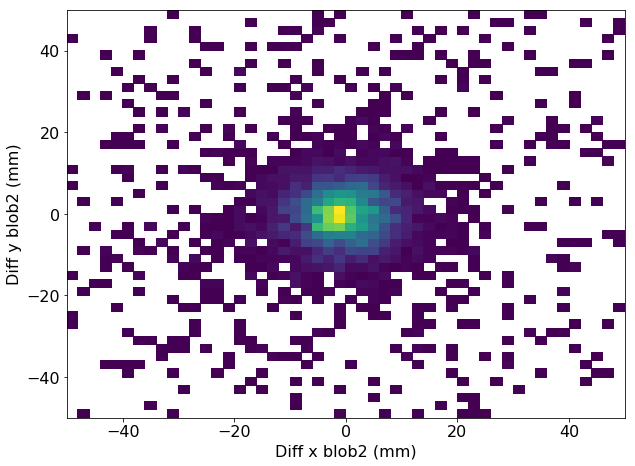

In [56]:
rng = 50 
plt.hist2d(diff2_x, diff2_y, bins=50, range=((-rng, rng), (-rng, rng)), cmin=0.001);
plt.xlabel("Diff x blob2 (mm)")
plt.ylabel("Diff y blob2 (mm)");

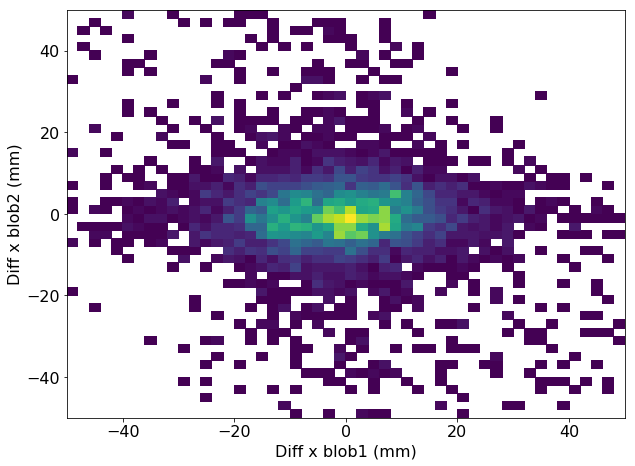

In [57]:
rng = 50 
plt.hist2d(diff1_x, diff2_x, bins=50, range=((-rng, rng), (-rng, rng)), cmin=0.001);
plt.xlabel("Diff x blob1 (mm)")
plt.ylabel("Diff x blob2 (mm)");

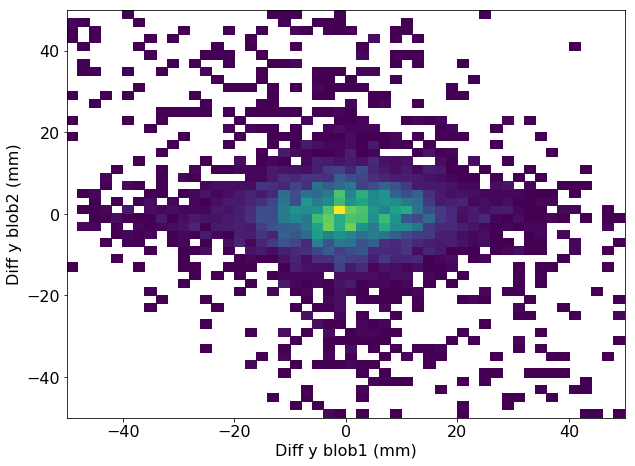

In [58]:
rng = 50 
plt.hist2d(diff1_y, diff2_y, bins=50, range=((-rng, rng), (-rng, rng)), cmin=0.001);
plt.xlabel("Diff y blob1 (mm)")
plt.ylabel("Diff y blob2 (mm)");

### Checks

In [52]:
## After Beersheba, have we already any events missing?
nfiles = 1000
start  = 1
bunch  = 20

reco_dfs = []

for i in range(start, start+nfiles):
    filename = folder_name + f'next100.e-_roi.{i}.deconv.h5'
    try:
        df = pd.read_hdf(filename, 'DECO/Events')     
    except:
        print('File {} not good'.format(filename))
        continue
    if df.event.nunique() != 10:
        print(df.event.unique())
    #reco_dfs.append(df)
    

[100 101 103 104 105 106 107 108 109]
[120 121 123 124 125 126 127 128 129]
[130 131 132 133 134 135 136 138 139]
[150 151 152 153 154 155 156 157 159]
[161 162 163 164 165 166 168 169]
[190 191 192 193 194 195 196 197 198]
[351 352 353 354 355 356 357 358]
[370 371 372 373 375 376 377 378 379]
[401 402 403 404 405 406 407 408 409]
[490 491 492 493 494 495 496 497 498]
[560 561 562 563 564 565 566 567 568]
[590 591 592 593 594 595 596 597 598]
[620 621 622 623 624 625 626 627 628]
[630 631 632 633 634 635 636 637 639]
[670 672 673 674 675 676 677 678 679]
[730 731 732 733 734 735 737 738 739]
[910 911 913 914 915 916 917 918 919]
[970 971 972 973 974 975 976 977 978]
[1000 1001 1002 1003 1005 1006 1007 1008 1009]
[1020 1021 1022 1023 1025 1026 1027 1028 1029]
[1060 1061 1062 1063 1064 1065 1066 1068 1069]
[1130 1131 1132 1133 1134 1135 1136 1138 1139]
[1170 1171 1172 1173 1174 1175 1176 1177 1179]
[1261 1262 1263 1264 1265 1266 1267 1268 1269]
[1290 1291 1292 1293 1294 1295 1296 1298 1

[8880 8882 8883 8884 8885 8886 8887 8888 8889]
[8890 8891 8892 8893 8895 8896 8897 8898 8899]
[8920 8921 8922 8923 8924 8926 8927 8928 8929]
[8990 8991 8992 8993 8994 8995 8996 8997 8998]
[9030 9031 9032 9033 9034 9036 9037 9038 9039]
[9040 9041 9043 9044 9045 9046 9047 9048 9049]
[9050 9051 9052 9053 9054 9055 9056 9057 9059]
[9250 9251 9252 9253 9254 9255 9256 9257 9259]
[9290 9291 9292 9294 9295 9296 9297 9298 9299]
[9330 9332 9333 9335 9336 9337 9338 9339]
[9360 9361 9363 9364 9365 9367 9368 9369]
[9400 9401 9402 9403 9404 9405 9406 9407 9408]
[9450 9452 9453 9454 9455 9456 9457 9458 9459]
[9490 9491 9492 9493 9494 9495 9497 9498 9499]
[9500 9501 9502 9503 9504 9505 9506 9507 9508]
[9610 9611 9612 9613 9614 9615 9616 9618 9619]
[9640 9641 9642 9644 9645 9646 9647 9648 9649]
[9770 9771 9772 9774 9775 9776 9777 9778 9779]
[9800 9801 9802 9803 9805 9806 9807 9808 9809]
[9880 9881 9882 9883 9884 9885 9886 9887 9888]
[9890 9891 9892 9893 9894 9896 9897 9898 9899]
[9940 9941 9942 9945 99

In [48]:
recos = pd.concat([df for df in reco_dfs])

In [49]:
recos.event.nunique()

9787

In [51]:
9787/10000.

0.9787

### Use Esmeralda to do basic cuts

In [199]:
radius = 21

cdst_folder = '/data_extra2/paolafer/SimMC/next100/tracks/esmeralda/'
trck_folder = f'/data_extra2/paolafer/SimMC/next100/tracks/R{radius}mm/'

tracks_list, cdst_list = [], []

start = 1
nfiles = 300
for file in range(start, start+nfiles):
    cdst_filename = cdst_folder + f'next100.e-_roi_10pes.{file}.cdst.h5'
    trck_filename = trck_folder + f'next100.e-_roi.{file}.skel_tracks.R{radius}mm.h5'
    try:
        df_t = pd.read_hdf(trck_filename, 'Tracks')
        df_c = pd.read_hdf(cdst_filename, 'Tracking/Tracks')
    except:
        print('File {} not good'.format(trck_filename))
        continue
    tracks_list.append(df_t)
    cdst_list.append(df_c)
    
tracks = pd.concat([dt for dt in tracks_list]) 
cdsts  = pd.concat([dc for dc in cdst_list]) 

In [200]:
cdsts.loc[:, 'evt_energy'] = cdsts.groupby('event')['energy'].transform('sum')
cdsts.loc[:, 'e_max']      = cdsts.groupby('event')['energy'].transform('max')

In [201]:
tracks.loc[:, 'evt_energy'] = tracks.groupby('event')['energy'].transform('sum')
tracks.loc[:, 'e_max']      = tracks.groupby('event')['energy'].transform('max')

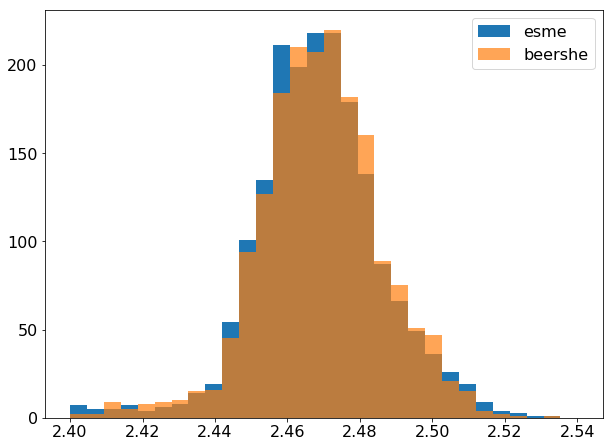

In [207]:
plt.hist(cdsts.groupby('event').energy.sum(), bins=30, range = (2.4, 2.54), label='esme');
plt.hist(tracks.groupby('event').energy.sum(), bins=30, range = (2.4, 2.54), alpha=0.7, label='beershe');
plt.legend(loc=1);

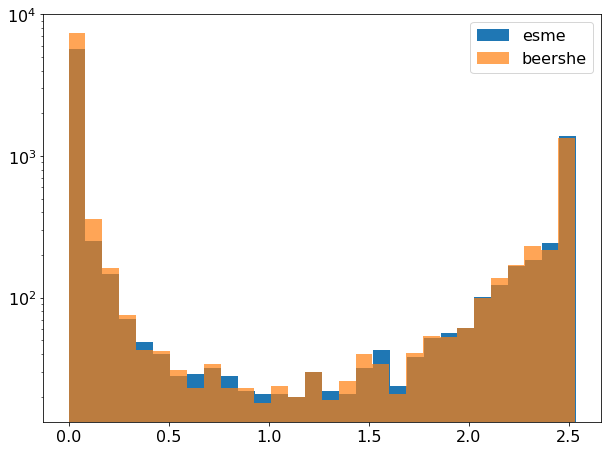

In [212]:
plt.hist(cdsts.energy, bins=30,  label='esme');
plt.hist(tracks.energy, bins=30, alpha=0.7, label='beershe');
plt.yscale('log')
plt.legend(loc=1);

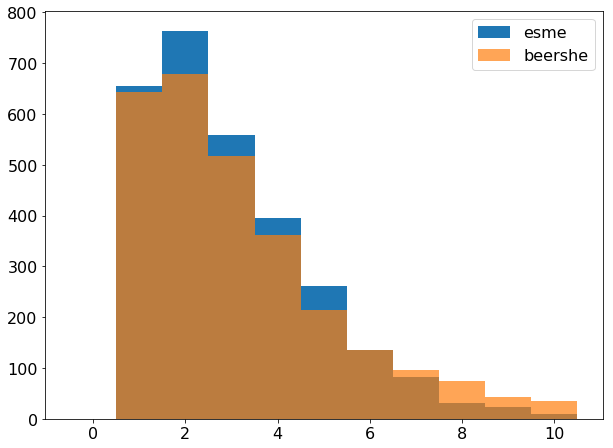

In [244]:
plt.hist(cdsts.groupby('event').numb_of_tracks.first(), bins=11, range=(-0.5, 10.5), label='esme')
plt.hist(tracks.groupby('event').numb_of_tracks.first(), bins=11, range=(-0.5, 10.5), alpha=0.7, label='beershe')
plt.legend(loc=1);

2937
Events after fiducial cut: 1651, efficiency = 0.5621382362955397
Events after 1-track cut: 238, efficiency = 0.1441550575408843
Events after no-overlap cut: 238, efficiency = 1.0


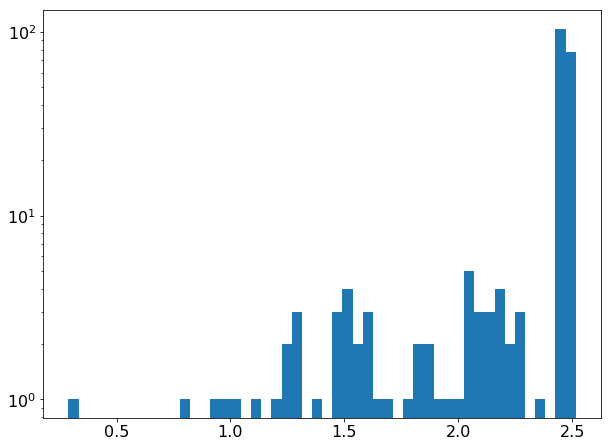

In [248]:
n_events_ini = cdsts.event.nunique()
print(n_events_ini)
fid = fiducialize_df(cdsts, r_max, z_min, z_max)
n_events_fid = fid.event.nunique()
print(f'Events after fiducial cut: {n_events_fid}, efficiency = {n_events_fid/n_events_ini}')
one_track = fid[fid.numb_of_tracks == 1]
n_events_1track = one_track.event.nunique()
print(f'Events after 1-track cut: {n_events_1track}, efficiency = {n_events_1track/n_events_fid}')
sep = one_track[one_track.ovlp_blob_energy == 0.]
n_events_no_overlap = sep.event.nunique()
print(f'Events after no-overlap cut: {n_events_no_overlap}, efficiency = {n_events_no_overlap/n_events_1track}')

plt.hist(sep.energy, bins=50);
plt.yscale('log')

In [252]:
multi_track = fid[fid.numb_of_tracks != 1]
print(len(multi_track))

5384


In [258]:
multi_track[multi_track.event == 3]

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,evt_energy,e_max
7,3,0,2.462413,192.095378,305,1364,6,-365.37,-209.87,657.392063,...,-132.12,663.119637,0.108789,0.032617,0.000000,14.7725,14.7725,13.0614,2.464302,2.462413
8,3,1,0.000661,14.772500,2,2,6,-256.52,-272.07,663.008000,...,-256.52,663.008000,0.000661,0.000661,0.000661,14.7725,14.7725,13.0614,2.464302,2.462413
9,3,2,0.000315,0.000000,1,1,6,-318.72,7.83,663.008000,...,7.83,663.008000,0.000315,0.000315,0.000315,14.7725,14.7725,13.0614,2.464302,2.462413
10,3,3,0.000313,0.000000,1,1,6,-412.02,-147.67,663.008000,...,-147.67,663.008000,0.000313,0.000313,0.000313,14.7725,14.7725,13.0614,2.464302,2.462413
11,3,4,0.000304,0.000000,1,1,6,-287.62,-256.52,663.008000,...,-256.52,663.008000,0.000304,0.000304,0.000304,14.7725,14.7725,13.0614,2.464302,2.462413
12,3,5,0.000297,0.000000,1,1,6,-380.92,-38.82,663.008000,...,-38.82,663.008000,0.000297,0.000297,0.000297,14.7725,14.7725,13.0614,2.464302,2.462413


In [253]:
len(one_track)

238

In [ ]:
fid = fiducialize_df(tracks, r_max, z_min, z_max)
n_events_fid = fid.event.nunique()
print(f'Events after fiducial cut: {n_events_fid}, efficiency = {n_events_fid/n_events_ini}')
one_track = fid[fid.numb_of_tracks == 1]
n_events_1track = one_track.event.nunique()
print(f'Events after 1-track cut: {n_events_1track}, efficiency = {n_events_1track/n_events_fid}')
sep = one_track[one_track.ovlp_blob_energy == 0.]
n_events_no_overlap = sep.event.nunique()
print(f'Events after no-overlap cut: {n_events_no_overlap}, efficiency = {n_events_no_overlap/n_events_1track}')

plt.hist(sep.energy, bins=50);
plt.yscale('log')

In [255]:
cdst_filename = cdst_folder + f'next100.e-_roi_10pes.1.cdst.h5'
df_c = pd.read_hdf(cdst_filename, 'CHITS/highTh')

In [257]:
df_c[df_c.event == 3]

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
3997,3,0.0,0,-219.139378,-103.82168,1,-396.47,-209.87,0.000000e+00,2.842171e-14,718.939750,10.202898,67.704028,-1.0,0.000430,-1,NaN
3998,3,0.0,0,-219.139378,-103.82168,1,-116.57,-116.57,0.000000e+00,0.000000e+00,661.124375,10.434782,57.132661,-1.0,0.000302,-1,NaN
3999,3,0.0,0,-219.139378,-103.82168,1,-396.47,-163.22,0.000000e+00,0.000000e+00,718.939750,15.130435,100.402003,-1.0,0.000606,-1,NaN
4000,3,0.0,0,-219.139378,-103.82168,1,-132.12,-69.92,0.000000e+00,0.000000e+00,663.008000,10.086956,52.647056,-1.0,0.000277,-1,NaN
4001,3,0.0,0,-219.139378,-103.82168,1,-380.92,-194.32,0.000000e+00,2.842171e-14,716.993687,11.826087,76.366234,-1.0,0.000455,-1,NaN
4002,3,0.0,0,-219.139378,-103.82168,1,-380.92,-194.32,0.000000e+00,0.000000e+00,718.939750,14.144928,93.862411,-1.0,0.000559,-1,NaN
4003,3,0.0,0,-219.139378,-103.82168,1,-163.22,-7.72,0.000000e+00,0.000000e+00,663.008000,12.579710,65.657538,-1.0,0.000347,-1,NaN
4004,3,0.0,0,-219.139378,-103.82168,1,-396.47,-147.67,0.000000e+00,0.000000e+00,718.939750,16.521740,109.634375,-1.0,0.000651,-1,NaN
4005,3,0.0,0,-219.139378,-103.82168,1,-132.12,-85.47,0.000000e+00,0.000000e+00,661.124375,11.130434,60.941505,-1.0,0.000321,-1,NaN
4006,3,0.0,0,-219.139378,-103.82168,1,-365.37,-209.87,0.000000e+00,0.000000e+00,713.024437,11.942029,84.804692,-1.0,0.000497,-1,NaN
